In [1]:
from utils import *
from build_model import *

'''
Dataset: Particles
Dataset: Particles_Classes
Dataset: Particles_Names

array([b'MET_class_1', b'Four_Ele_class_2', b'Four_Mu_class_3',
       b'Ten_Jet_class_4'], dtype='|S16')
       
array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')

shape = (n, 19, 4)
'''

files = ['background_for_training.h5',
         'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5',
         'Ato4l_lepFilter_13TeV_filtered.h5',
         'hChToTauNu_13TeV_PU20_filtered.h5',
         'hToTauTau_13TeV_PU20_filtered.h5']

sig_names = ['leptoquark', 'Ato4l', 'hChToTauNu', 'hToTauTau']

data = []
for i in range(len(files)):
    with h5py.File('dataset/'+files[i], 'r') as hdf:
        if i == 0:
            data.append(hdf['Particles'][:300000])
        else:
            data.append(hdf['Particles'][:])
    print(data[i].shape)

data[1][2]

(300000, 19, 4)
(340544, 19, 4)
(55969, 19, 4)
(760272, 19, 4)
(691283, 19, 4)


array([[ 35.73933792,   0.        ,  -2.28784204,   1.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ 27.04832458,  -0.34886953,   2.64276648,   3.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [125.30833435,  -1.33076048,  -0.42175815,   4.        ],
       [119.50546265,  -0.30792901,   2.6104064 ,   4.        ],
       [ 21.65406036,   0.22015911,   0.24171966,   4.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0

In [ ]:
plot_data(data, 'MET')
plot_data(data, 'Ele')
plot_data(data, 'Mu')
plot_data(data, 'Jet')

## preprocess data

In [2]:
# remove last feature (particle class), which is implicitly assumed in second index ordering
for i in range(len(data)):
    data[i] = np.reshape(data[i][:,:,:3], (data[i].shape[0], -1))

# training data: bkg only
X = data[0]

train_ratio = 0.6
val_ratio = 0.001
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 42)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
del X_train_val

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

sig = []
for i in range(4):
    sig.append(scaler.transform(data[i+1]))

del data

X_train shape: (180000, 57)
X_val   shape: (300, 57)
X_test  shape: (119700, 57)


## baseline ae model

In [ ]:
model_ae = build_autoencoder(input_dim=57, q=True)
model_ae.summary()

In [ ]:
history = model_ae.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=60, batch_size=256)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'train')
axes.plot(history.history['val_loss'], label = 'val')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

score_bkg_ae = compute_mse_for_ae(model_ae, X_test)
score_sig_ae = []
for i in range(4):
    score_sig_ae.append(compute_mse_for_ae(model_ae, sig[i]))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(score_bkg_ae, bins=100, alpha=0.5, label='Bkg', density=1)

for i, score_vals in enumerate(score_sig_ae):
    plt.hist(score_vals, bins=100, label=f'{sig_names[i]}', density=1, histtype='step')

plt.xlabel('MSE')
plt.xlim((0,10))
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([score_bkg_ae, score_sig_ae[i]])
    labels = np.concatenate([np.zeros_like(score_bkg_ae), np.ones_like(score_sig_ae[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

In [ ]:
if os.path.exists('weights/weights_ae.h5'):
    os.remove('weights/weights_ae.h5')

model_ae.save_weights('weights/weights_ae.h5')

## baseline vae model

In [ ]:
epochs = 60
batch_size = 256
beta = 0.5

vae, vae_encoder, vae_decoder = build_vae(input_dim=57, beta=beta)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(10000).batch(batch_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

train_reco_losses = []
train_kl_losses = []
for epoch in range(epochs):
    epoch_reco_loss = 0
    epoch_kl_loss = 0
    num_batches = 0
    for x_batch in train_dataset:
        with tf.GradientTape() as tape:
            z_mean_batch, z_log_var_batch = vae_encoder(x_batch, training=True)
            z_batch = vae_sampling((z_mean_batch, z_log_var_batch))
            reco = vae_decoder(z_batch, training=True)

            reco_loss = tf.reduce_mean(tf.square(tf.cast(x_batch, tf.float32) - tf.cast(reco, tf.float32)))

            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var_batch - tf.square(z_mean_batch) - tf.exp(z_log_var_batch), axis=-1)
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = (1 - beta) * reco_loss + beta * kl_loss

        grads = tape.gradient(total_loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))
        
        epoch_reco_loss += reco_loss.numpy()
        epoch_kl_loss += kl_loss.numpy()
        num_batches += 1

    reco_loss_avg = epoch_reco_loss / num_batches
    kl_loss_avg = epoch_kl_loss / num_batches

    train_reco_losses.append(reco_loss_avg)
    train_kl_losses.append(kl_loss_avg)

    print(f"Epoch {epoch+1}/{epochs}: mse: {reco_loss_avg:.4f}, kl: {kl_loss_avg:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_reco_losses, label='mse')
plt.plot(range(1, epochs+1), train_kl_losses, label='kl')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

score_bkg_vae_kl = compute_kl_for_vae(vae_encoder, X_test)
score_bkg_vae_r  = compute_r_for_vae(vae_encoder, X_test)
score_sig_vae_kl = []
score_sig_vae_r = []
for i in range(4):
    score_sig_vae_kl.append(compute_kl_for_vae(vae_encoder, sig[i]))
    score_sig_vae_r.append(compute_r_for_vae(vae_encoder, sig[i]))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(score_bkg_vae_kl, bins=100, alpha=0.5, label='Bkg', density=True)

for i, score_vals in enumerate(score_sig_vae_kl):
    plt.hist(score_vals, bins=100, label=f'{sig_names[i]}', density=True, histtype='step')

plt.xlabel('KL')
#plt.xlim((0,10000))
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(score_bkg_vae_r, bins=100, alpha=0.5, label='Bkg', density=True)

for i, score_vals in enumerate(score_sig_vae_r):
    plt.hist(score_vals, bins=100, label=f'{sig_names[i]}', density=True, histtype='step')

plt.xlabel('R_z')
#plt.xlim((0,10000))
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
colors = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([score_bkg_vae_kl, score_sig_vae_kl[i]])
    labels = np.concatenate([np.zeros_like(score_bkg_vae_kl), np.ones_like(score_sig_vae_kl[i])])
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (KL) (AUC = {roc_auc:.3f})', color=colors[i], linestyle='-')

    errors = np.concatenate([score_bkg_vae_r, score_sig_vae_r[i]])
    labels = np.concatenate([np.zeros_like(score_bkg_vae_r), np.ones_like(score_sig_vae_r[i])])
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (Rz) (AUC = {roc_auc:.3f})', color=colors[i], linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

In [ ]:
if os.path.exists('weights/weights_vae_encoder.h5'):
    os.remove('weights/weights_vae_encoder.h5')

vae_encoder.save_weights('weights/weights_vae_encoder.h5')

## flow model

Epoch 1/30, Loss: -2.5794
Epoch 2/30, Loss: -7.0660
Epoch 3/30, Loss: -8.4970
Epoch 4/30, Loss: -9.3609
Epoch 5/30, Loss: -9.7933
Epoch 6/30, Loss: -10.4102
Epoch 7/30, Loss: -10.1358
Epoch 8/30, Loss: -10.4798
Epoch 9/30, Loss: -10.5654
Epoch 10/30, Loss: -10.5651
Epoch 11/30, Loss: -10.6965
Epoch 12/30, Loss: -10.8927
Epoch 13/30, Loss: -9.6844
Epoch 14/30, Loss: -10.6973
Epoch 15/30, Loss: -10.7657
Epoch 16/30, Loss: -11.0437
Epoch 17/30, Loss: -11.0520
Epoch 18/30, Loss: -10.7588
Epoch 19/30, Loss: -11.0698
Epoch 20/30, Loss: -11.0665
Epoch 21/30, Loss: -10.8844
Epoch 22/30, Loss: -10.4637
Epoch 23/30, Loss: -11.5175
Epoch 24/30, Loss: -11.0747
Epoch 25/30, Loss: -10.7566
Epoch 26/30, Loss: -11.5114
Epoch 27/30, Loss: -11.1523
Epoch 28/30, Loss: -9.7269
Epoch 29/30, Loss: -11.3264
Epoch 30/30, Loss: -11.1816


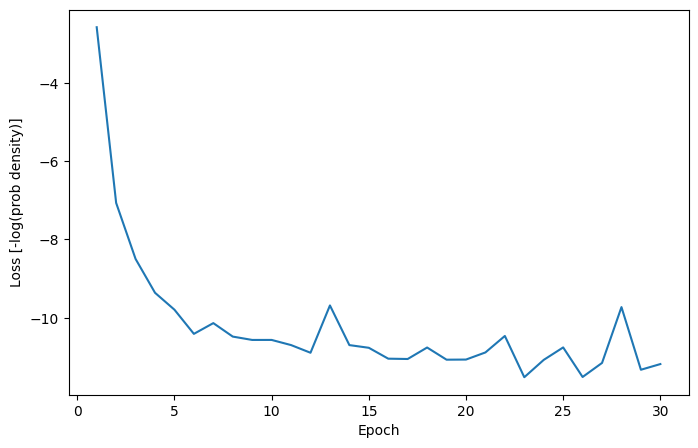

In [3]:
epochs = 30
batch_size = 256

model_nf = NormalizingFlowModel(num_flows=3, q=True)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(10000).batch(batch_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)

epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch in train_dataset:
        with tf.GradientTape() as tape:
            loss = nll_loss(model_nf, x_batch)
        grads = tape.gradient(loss, model_nf.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_nf.trainable_variables))
        epoch_loss += loss.numpy()
        num_batches += 1
    avg_loss = epoch_loss / num_batches
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs+1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss [-log(prob density)]")
plt.show()

score_bkg_nf = compute_nll_for_nf(model_nf, X_test)
score_sig_nf = []
for i in range(4):
    score_sig_nf.append(compute_nll_for_nf(model_nf, sig[i]))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(score_bkg_nf, bins=1000, alpha=0.5, label='Bkg', density=True)

for i, nll_vals in enumerate(score_sig_nf):
    plt.hist(nll_vals, bins=1000, label=f'{sig_names[i]}', density=True, histtype='step')

plt.xlabel('Negative Log-Likelihood')
plt.ylabel('Density')
plt.xlim((-50,100))
plt.yscale('log')
plt.legend()
plt.show()

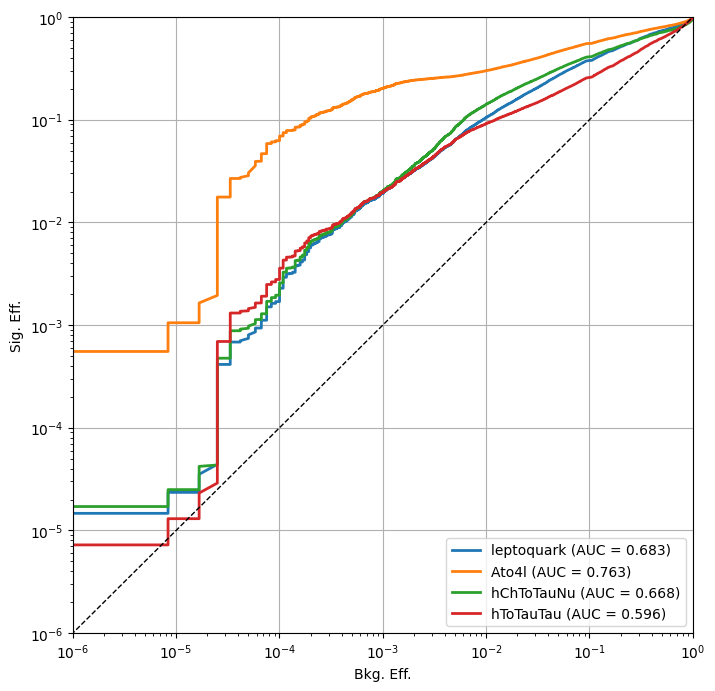

In [4]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([score_bkg_nf, score_sig_nf[i]])
    labels = np.concatenate([np.zeros_like(score_bkg_nf), np.ones_like(score_sig_nf[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

In [ ]:
if os.path.exists('weights/weights_nf.h5'):
    os.remove('weights/weights_nf.h5')

model_nf.save_weights('weights/weights_nf.h5')

## compare models

In [ ]:
model_ae = build_autoencoder(input_dim=57)
model_ae.load_weights('weights/weights_ae.h5')

score_bkg_ae = compute_mse_for_ae(model_ae, X_test)
score_sig_ae = []
for i in range(4):
    score_sig_ae.append(compute_mse_for_ae(model_ae, sig[i]))

In [ ]:
vae_encoder = build_vae(input_dim=57, beta=0.5)[1]
vae_encoder.load_weights('weights/weights_vae_encoder.h5')

score_bkg_vae_kl = compute_kl_for_vae(vae_encoder, X_test)
score_bkg_vae_r  = compute_r_for_vae(vae_encoder, X_test)
score_sig_vae_kl = []
score_sig_vae_r = []
for i in range(4):
    score_sig_vae_kl.append(compute_kl_for_vae(vae_encoder, sig[i]))
    score_sig_vae_r.append(compute_r_for_vae(vae_encoder, sig[i]))

In [ ]:
model_nf = NormalizingFlowModel(num_flows=3)
model_nf.load_weights('weights/weights_nf.h5')

score_bkg_nf = compute_nll_for_nf(model_nf, X_test)
score_sig_nf = []
for i in range(4):
    score_sig_nf.append(compute_nll_for_nf(model_nf, sig[i]))

In [ ]:
colors = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([score_bkg_nf, score_sig_nf[i]])
    labels = np.concatenate([np.zeros_like(score_bkg_nf), np.ones_like(score_sig_nf[i])])
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (NF) (AUC = {roc_auc:.3f})', color=colors[i], linestyle='-')

    errors = np.concatenate([score_bkg_vae_kl, score_sig_vae_kl[i]])
    labels = np.concatenate([np.zeros_like(score_bkg_vae_kl), np.ones_like(score_sig_vae_kl[i])])
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (VAE-KL) (AUC = {roc_auc:.3f})', color=colors[i], linestyle='--')

    errors = np.concatenate([score_bkg_vae_r, score_sig_vae_r[i]])
    labels = np.concatenate([np.zeros_like(score_bkg_vae_r), np.ones_like(score_sig_vae_r[i])])
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (VAE-Rz) (AUC = {roc_auc:.3f})', color=colors[i], linestyle='dotted')

    #errors = np.concatenate([score_bkg_ae, score_sig_ae[i]])
    #labels = np.concatenate([np.zeros_like(score_bkg_ae), np.ones_like(score_sig_ae[i])])
    #fpr, tpr, thresholds = roc_curve(labels, errors)
    #roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=2, label=f'{sig_names[i]} (AE) (AUC = {roc_auc:.3f})', color=colors[i], linestyle='dotted')


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

## hls

In [ ]:
model_nf = NormalizingFlowModel(num_flows=3)
model_nf.load_weights('weights/weights_nf.h5')

#print("dense 1 weights:", model_nf.dense1.get_weights())
#print("dense 2 weights:", model_nf.dense2.get_weights())
#print("dense 3 weights:", model_nf.dense3.get_weights())

for i, flow in enumerate(model_nf.flows):
    print(f'--------flow layer {i}--------')
    for weight in flow.weights:
        print(f'{weight.name}: shape = {weight.shape}')
        print(str(weight.numpy()) + '\n')

In [ ]:
input_layer = tf.keras.Input(shape=(57,), name='x_in')
x = model_nf.dense1(input_layer)
x = model_nf.act1(x)
x = model_nf.dense2(x)
x = model_nf.act2(x)
x = model_nf.dense3(x)
x = model_nf.act3(x)
model = tf.keras.Model(inputs=input_layer, outputs=x)

In [ ]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model']['Strategy'] = 'Latency'
config['LayerName']['x_in']['Precision'] = 'ap_fixed<12, 4, AP_RND, AP_SAT>'

config

In [ ]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    project_name='model_test',
    output_dir='model_test',
    part='xcvu13p-flga2577-2-e',
    io_type='io_parallel',
)

hls_model.compile()
hls_model.write()

## test bench

In [ ]:
X_test.shape

In [ ]:
def round_sig(x, sig=4):
    if x == 0:
        return 0
    decimals = sig - int(np.floor(np.log10(abs(x)))) - 1
    return round(x, decimals)

np.random.seed(42)
#arr_in = np.zeros((3, 57))
arr_in = np.random.uniform(low=-10, high=10, size=(3, 57))
arr_out = np.zeros((3, 4))

round_sig_vec = np.vectorize(round_sig)
arr_in = round_sig_vec(arr_in, 4)

In [ ]:
with open('model_test/tb_data/tb_input_features.dat', 'w') as my_file:
    for sample in arr_in.reshape(-1, np.prod(arr_in.shape[1:])):
        my_file.write(' '.join(str(x) for x in sample))
        my_file.write('\n')

with open('model_test/tb_data/tb_output_predictions.dat', 'w') as my_file:
    for sample in arr_out.reshape(-1, np.prod(arr_out.shape[1:])):
        my_file.write(' '.join(str(x) for x in sample))
        my_file.write('\n')